# Albert fine-tuned with Ag_News_Subset Colab

This notebook load a pre-trained albert model from tf hub and run fine-tuning with ag_news_subset from tfds.

In [1]:
import os
import time
import datetime
import pandas as pd
from tensorflow import keras
import pickle
import json
import re
import keras
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Tue Mar  2 10:43:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install and import Tensrflow Modules

Import TensorFlow and Tensorflow Hub

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.version.VERSION)

2.4.1


Install TensorFLow Official Models

In [4]:
# pip install tf-models-official

In [5]:
# pip install tfds-nightly

## Cola Dataset

### Download dataset from TFDS

Download the dataset from TFDS and split into train/dev/test or train/test.

In [6]:
import tensorflow_datasets as tfds

# (train_data, test_data, dev_data), info = tfds.load('ag_news_subset',
#                                                      split=['train[:83%]', 'train[83%:]', 'test[:100%]'],
#                                                      as_supervised=True,
#                                                      with_info=True
#                                                      )

(train_data, test_data, val_data), info = tfds.load('glue/cola',
                                          split=['train[:100%]', 'test[:100%]','validation[:100%]'],
                                          as_supervised=False,
                                          with_info=True
                                          )

In [7]:
print(info)

tfds.core.DatasetInfo(
    name='glue',
    full_name='glue/cola/1.0.0',
    description="""
    GLUE, the General Language Understanding Evaluation benchmark
    (https://gluebenchmark.com/) is a collection of resources for training,
    evaluating, and analyzing natural language understanding systems.
    """,
    config_description="""
    The Corpus of Linguistic Acceptability consists of English
    acceptability judgments drawn from books and journal articles on
    linguistic theory. Each example is a sequence of words annotated
    with whether it is a grammatical English sentence.
    """,
    homepage='https://nyu-mll.github.io/CoLA/',
    data_path='/root/tensorflow_datasets/glue/cola/1.0.0',
    download_size=368.14 KiB,
    dataset_size=965.49 KiB,
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=None,
    splits={
     

### Dataset Preprocessing

Convert Tensors to Pandas Dataframe

In [8]:
df_train = tfds.as_dataframe(train_data, info)
df_test = tfds.as_dataframe(test_data, info)
df_val = tfds.as_dataframe(val_data, info)

Dataset Shapes and Labels Balancement

In [9]:
df_train.shape

(8551, 3)

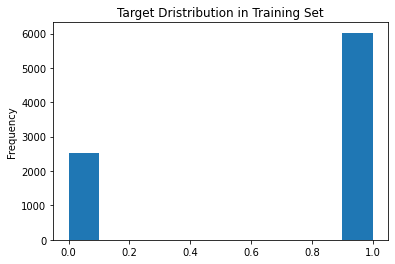

In [10]:
df_train.label.plot(kind='hist', title='Target Dristribution in Training Set')

In [11]:
df_val.shape

(1043, 3)

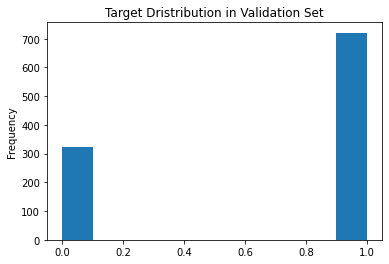

In [12]:
df_val.label.plot(kind='hist', title='Target Dristribution in Validation Set')

In [13]:
df_test.shape

(1063, 3)

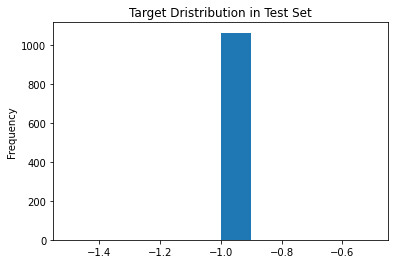

In [14]:
df_test.label.plot(kind='hist', title='Target Dristribution in Test Set')

In [15]:
df_train.head()

,idx,label,sentence
0,1680,1,b'It is this hat that it is certain that he wa...
1,1456,1,b'Her efficient looking up of the answer pleas...
2,4223,1,b'Both the workers will wear carnations.'
3,4093,1,b'John enjoyed drawing trees for his syntax ho...
4,7111,1,"b'We consider Leslie rather foolish, and Lou a..."


Decode `sentence` column from Train and Test datasets

In [16]:
df_train['sentence'] = df_train['sentence'].str.decode('utf8')
df_val['sentence'] = df_val['sentence'].str.decode('utf8')
df_test['sentence'] = df_test['sentence'].str.decode('utf8')

Visualize first rows of the dataframe

In [17]:
df_train.head(5)

,idx,label,sentence
0,1680,1,It is this hat that it is certain that he was ...
1,1456,1,Her efficient looking up of the answer pleased...
2,4223,1,Both the workers will wear carnations.
3,4093,1,John enjoyed drawing trees for his syntax home...
4,7111,1,"We consider Leslie rather foolish, and Lou a c..."


In [18]:
df_val.head(5)

,idx,label,sentence
0,878,1,That picture of Susan offended her.
1,787,0,I noticed the.
2,458,0,Mary revealed himself to John.
3,423,1,Frank Churchill crossed the street.
4,466,0,Everyone hopes everyone to sleep.


In [19]:
df_test.head(5)

,idx,label,sentence
0,163,-1,Brian was wiping behind the stove.
1,131,-1,You could give a headache to a Tylenol.
2,1021,-1,I want to meet at 6.
3,166,-1,Packages carry easily.
4,1039,-1,Many people said they were sick who weren't.


Save the original dataset and the cleaned dataset

In [20]:
FINE_TUNING_DIR = "/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola"

DATASET_DIR = os.path.join(FINE_TUNING_DIR, "dataset")
MODEL_DIR = os.path.join(FINE_TUNING_DIR, "model")

In [21]:
mkdir '$FINE_TUNING_DIR'

mkdir: cannot create directory ‘/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola’: File exists


In [22]:
mkdir '$DATASET_DIR'

mkdir: cannot create directory ‘/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola/dataset’: File exists


In [23]:
mkdir '$MODEL_DIR'

mkdir: cannot create directory ‘/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola/model’: File exists


In [24]:
df_train.to_csv(os.path.join(DATASET_DIR,"df_train.csv"))
df_val.to_csv(os.path.join(DATASET_DIR,"df_val.csv"))
df_test.to_csv(os.path.join(DATASET_DIR,"df_test.csv"))

Convert train and test dataframe into tensors

In [25]:
train_data = tf.data.Dataset.from_tensor_slices((df_train.sentence, df_train.label))
val_data = tf.data.Dataset.from_tensor_slices((df_val.sentence, df_val.label))
test_data = tf.data.Dataset.from_tensor_slices((df_test.sentence, df_test.label))

In [26]:
del df_train
del df_test
del df_val

## AlbertModel Class

In [27]:
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
import tensorflow_addons as tfa

class AlbertModel:
  def __init__(self):

    self.pretrained_albert_layer = None
    self.sp_model_file = None
    self.tokenizer = None
    self.num_classes = None
    self.max_seq_length = None
    self.label_list = None
    self.TF_HUB_URL = "https://tfhub.dev/tensorflow/albert_en_base/2"


    self.info_dict = {}
    return

  def load_pretrained_albert_tf_hub_from_url(self, url=None, trainable_flag=True):
    if url is None:
      url = self.TF_HUB_URL
    self.pretrained_albert_layer = hub.KerasLayer(url, trainable=trainable_flag)
    self.pretrained_albert_layer._name = "albert_layer"
    
    self.info_dict.update({"trained_albert_weights":trainable_flag})
    return

  def load_pretrained_albert_tf_hub_from_dir(self, tf_hub_model_dir):
    self.pretrained_albert_layer = hub.KerasLayer(tf_hub_model_dir, trainable=trainable_flag)
    self.pretrained_albert_layer._name = "albert_layer"

    self.info_dict.update({"trained_albert_weights":trainable_flag})
    return

  
  def load_model(self, model_directory):
    # Load Tokenizer 
    with open(os.path.join(model_directory, "albert_tokenizer.pickle"), "rb") as tokenizer_file:
        self.tokenizer = pickle.load(tokenizer_file)

    # Load Model
    self.model = keras.models.load_model(model_directory)

    # Read from metadata file the max_seq_length
    with open(os.path.join(model_directory, "metadata", "experimenti_info.json"), "rb") as metadata_file:
      self.info_dict = json.load(metadata_file)
      self.max_seq_length = self.info_dict["max_seq_length"]

    # Load the feature extractor (albert layer)
    self.extractor = tf.keras.Model(inputs=self.model.inputs,
                                    outputs=[self.model.get_layer("albert_layer").output])

    print("INFO: model loaded")
    self.model.summary()
    print("INFO: features extractor loaded")
    self.extractor.summary()
    return


  def create_model(self, num_classes, label_list, label_names=None, dropout_percentage=0.2, max_seq_length=256):

    self.num_classes = num_classes
    self.max_seq_length = max_seq_length
    self.label_list = label_list

    if self.num_classes > 2:
      activation_function = "softmax"
    else:
      activation_function = "sigmoid"

    # Save parameters setting
    self.info_dict.update({"num_classes":num_classes, "label_list":label_list, "label_names":label_names, 
                           "dropout_percentage":dropout_percentage, "max_seq_length":max_seq_length, "output_activation":activation_function})


    # Define Albert inputs
    input_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                          name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")
    
    albert_inputs = dict(input_word_ids=input_ids,
                      input_mask=input_mask,
                      input_type_ids=segment_ids)
    
    # Define Albert block
    albert_outputs = self.pretrained_albert_layer(albert_inputs)

    self.sp_model_file = self.pretrained_albert_layer.resolved_object.sp_model_file.asset_path.numpy()
    self.tokenizer = tokenization.FullSentencePieceTokenizer(self.sp_model_file)

    #pooled_output = albert_outputs["pooled_output"]
    #sequence_output = albert_outputs["sequence_output"]

    drop = tf.keras.layers.Dropout(dropout_percentage)(albert_outputs["pooled_output"])

    classification_output = tf.keras.layers.Dense(num_classes, activation=activation_function, name="classification")(drop)

    model = tf.keras.Model(
        inputs=albert_inputs,
        outputs=classification_output
    )

    self.model = model
    
    return

  def fit(self, train_data, test_data, epochs, batch_size, shuffle_batch_size=10000, verbose=1, drop_remainder=False):

    self.info_dict.update({"epochs":epochs, "batch_size":batch_size, "shuffle_batch_size":shuffle_batch_size})

    with tf.device('/cpu:1'):
          # train
          train_data = (train_data.map(self.to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                  .shuffle(shuffle_batch_size)
                                  .batch(batch_size, drop_remainder=drop_remainder)
                                  .prefetch(tf.data.experimental.AUTOTUNE))
          # valid
          test_data = (test_data.map(self.to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                .batch(batch_size, drop_remainder=drop_remainder)
                                .prefetch(tf.data.experimental.AUTOTUNE))

    self.history = self.model.fit(train_data,
                            validation_data=test_data,
                            epochs=epochs,
                            verbose=verbose)
    
    return self.history

  def compile(self, learning_rate=2e-5, loss="sparse_categorical_crossentropy", metrics=['accuracy']):
    self.info_dict.update({"learning_rate":learning_rate, "loss":loss.__str__(), "metrics":metrics})

    self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    #self.model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate),
                        loss=loss,
                        metrics=metrics
                        )


    return

  def to_feature(self, text, label):
      example = classifier_data_lib.InputExample(guid=None,
                                                  text_a=text.numpy(),
                                                  text_b=None,
                                                  label=label.numpy())

      feature = classifier_data_lib.convert_single_example(0, example, self.label_list, self.max_seq_length, self.tokenizer)

      return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  def to_feature_map(self, text, label):
      input_ids, input_mask, segment_ids, label_id = tf.py_function(self.to_feature,
                                                                    inp=[text, label],
                                                                    Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

      input_ids.set_shape([self.max_seq_length])
      input_mask.set_shape([self.max_seq_length])
      segment_ids.set_shape([self.max_seq_length])
      label_id.set_shape([])

      x = {
          'input_word_ids': input_ids,
          'input_mask': input_mask,
          'input_type_ids': segment_ids
      }

      return (x, label_id)

  def save_model(self, folder_name, experiment_description=None):
        if folder_name is None:
            ts = time.time()
            folder_name = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S')

        if experiment_description is None:
            out_name = '{}_albert_model'.format(folder_name)
        else:
            out_name = '{}_albert_model_{}'.format(folder_name, experiment_description)

        output_path = os.path.join(folder_name, out_name)
        metadata_path = os.path.join(output_path, "metadata")
        try:
            os.mkdir(output_path)
            os.mkdir(metadata_path)
        except OSError:
            print("Creation of the output directory %s failed" % output_path)

        # convert the history.history dict to a pandas DataFrame:
        hist_df = pd.DataFrame(self.history.history)

        # save to json:
        hist_json_file = '{}_history.json'.format(folder_name)
        hist_json_fie_path = os.path.join(metadata_path, hist_json_file)
        with open(hist_json_fie_path, mode='w+') as f:
            hist_df.to_json(f)

        self.model.save(output_path)

        with open(os.path.join(output_path, 'albert_tokenizer.pickle'), 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(output_path, 'metadata', 'experiment_info.json'), 'w') as fp:
            json.dump(self.info_dict, fp)

        print("INFO: Model saved in path: ", output_path)
        return output_path


  def summary(self):
    self.model.summary()
    return

  def get_model(self):
    return self.model

  def get_tokenizer(self):
    return self.tokenizer




## Create an instance of AlbertModel

Define TF_HUB_URL and TF_HUB_DIR 


In [28]:
TF_HUB_DIR = "/content/drive/MyDrive/saved_models/pre_trained/albert_base/albert_en_base_2"
TF_HUB_URL = "https://tfhub.dev/tensorflow/albert_en_base/2"

### Optional: Download TF_HUB_MODULE

Uncomment these lines if want to download and tar the TF Hub Module on local drive.

In [29]:
# !wget "https://storage.googleapis.com/tfhub-modules/tensorflow/albert_en_base/2.tar.gz"

In [30]:
# mkdir '$TF_HUB_DIR'

In [31]:
# !tar -xvf  '2.tar.gz' -C '$TF_HUB_DIR'


### Define, Create and Load Model

Define model parameters and settings

In [32]:
LABEL_LIST = [0,1]
LABEL_NAMES = ["Unacceptable", "Acceptable"]
NUM_CLASSES = len(LABEL_LIST)
max_seq_length = 128
activation_function = "sigmoid"
learning_rate = 1e-5
dropout_perc = 0.2

Create and instance of the AlbertModel Class

In [33]:
albert_model = AlbertModel()

Optional: Load tf_hub_module from local drive (only if previously have downloaded and unzipped in local drive).

In [34]:
# albert_model.load_pretrained_albert_tf_hub_from_dir(TF_HUB_DIR)

Load TF_HUB_MODULE from URL

In [35]:
albert_model.load_pretrained_albert_tf_hub_from_url(TF_HUB_URL)

Create the full model and print the summary

In [36]:
albert_model.create_model(num_classes=NUM_CLASSES, label_list=LABEL_LIST, label_names=LABEL_NAMES, dropout_percentage=dropout_perc, max_seq_length=max_seq_length)
albert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
albert_layer (KerasLayer)       {'pooled_output': (N 11683584    input_mask[0][0]                 
                                                                 segment_ids[0][0]            

## Training

### Compile the model
Compile the model with sparse_categorical_crossentropy loss and Adam optimizer

In [37]:
metrics = ['accuracy']
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
albert_model.compile(learning_rate=learning_rate, loss=loss, metrics=metrics)

Define trainig parameters

In [38]:
EPOCHS = 4
BATCH_SIZE = 8

### Run training
Train the model

In [39]:
history = albert_model.fit(train_data, val_data, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/4
1069/1069 [==============================] - 566s 511ms/step - loss: 0.6575 - accuracy: 0.6706 - val_loss: 0.5617 - val_accuracy: 0.7076
Epoch 2/4
1069/1069 [==============================] - 552s 510ms/step - loss: 0.5408 - accuracy: 0.7411 - val_loss: 0.5000 - val_accuracy: 0.7565
Epoch 3/4
1069/1069 [==============================] - 552s 510ms/step - loss: 0.4151 - accuracy: 0.8235 - val_loss: 0.4783 - val_accuracy: 0.7728
Epoch 4/4
1069/1069 [==============================] - 552s 510ms/step - loss: 0.2845 - accuracy: 0.8848 - val_loss: 0.5245 - val_accuracy: 0.7632


### Plot loss and accuracy

Define plot_history function

In [40]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1,len(acc) +1)

  plt.plot(epochs,acc, 'bo' , label="Training acc")
  plt.plot(epochs,val_acc, 'b' , label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.legend()

  plt.figure()

  plt.plot(epochs,loss, 'bo' , label="Training loss")
  plt.plot(epochs,val_loss, 'b' , label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()

  plt.show()
  return

Plot accuracy and loss

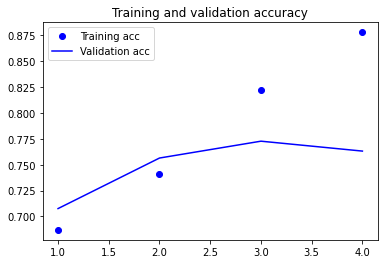

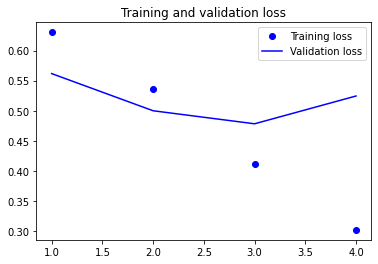

In [41]:
plot_history(history)

## Save Model

In [42]:
albert_model.save_model(MODEL_DIR)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola/model_albert_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola/model_albert_model/assets


INFO: Model saved in path:  /content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola/model_albert_model


'/content/drive/MyDrive/saved_models/fine_tuned/ebano_albert_cola/model_albert_model'